In [1]:
# Improtng all the dependancies
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import hvplot.pandas
import numpy as np
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="UofT_project_1")

In [2]:
# Please remember to put the path to respective datasets
stock_data = pd.read_csv(r"C:\Users\ulyan\UTOR-VIRT-DATA-PT-02-2024-U-LOLC\project_data\sp500_stocks.csv")
companies_data = pd.read_csv(r"C:\Users\ulyan\UTOR-VIRT-DATA-PT-02-2024-U-LOLC\project_data\sp500_companies.csv")
inflation = pd.read_excel(r"C:\Users\ulyan\UTOR-VIRT-DATA-PT-02-2024-U-LOLC\project_data\inflation.xlsx")
unemployment = pd.read_excel(r"C:\Users\ulyan\UTOR-VIRT-DATA-PT-02-2024-U-LOLC\project_data\unemployment.xlsx")
mortgage = pd.read_csv(r"C:\Users\ulyan\UTOR-VIRT-DATA-PT-02-2024-U-LOLC\project_data\US_mortgages.csv")

- ## Data Cleaning

In [38]:
# Industiries data

# Dropping unnecessary columns 
industry_data = companies_data.drop(["Weight", "Longbusinesssummary", "Shortname", "Exchange"], axis=1).copy()

# Scaling Ebitda column and showing to two decimal points 
industry_data["Ebitda"] = industry_data["Ebitda"]/1000000
industry_data["Ebitda"] = industry_data["Ebitda"].apply(lambda x: f"{x:.2f}")

# Selecting and converting columns that might be used in future analysis to numeric data types
columns_for_convert = ["Currentprice", "Ebitda", "Revenuegrowth", "Fulltimeemployees"]
for i in columns_for_convert:
    industry_data[i] = pd.to_numeric(industry_data[i], errors="coerce")

# Renaming the Ebitda column to understand the real value
industry_data.rename(columns={"Ebitda": "Ebitda (mil)"}, inplace=True)

# Showing the resulted dataframe 
industry_data.head()

Symbol               Longname                  Sector  \
0   MSFT  Microsoft Corporation              Technology   
1   AAPL             Apple Inc.              Technology   
2   NVDA     NVIDIA Corporation              Technology   
3   GOOG          Alphabet Inc.  Communication Services   
4  GOOGL          Alphabet Inc.  Communication Services   

                         Industry  Currentprice      Marketcap  Ebitda (mil)  \
0       Software - Infrastructure        426.28  3167447941120      118427.0   
1            Consumer Electronics        169.67  2620027043840      130109.0   
2                  Semiconductors        853.54  2133849931776       34480.0   
3  Internet Content & Information        158.14  1958832766976      100172.0   
4  Internet Content & Information        156.60  1953130872832      100172.0   

   Revenuegrowth           City State        Country  Fulltimeemployees  
0          0.176        Redmond    WA  United States           221000.0  
1          0.021      Cupertino    CA  United States           161000.0  
2          2.653    Santa Clara    CA  United States            29600.0  
3          0.135  Mountain View    CA  United States           182502.0  
4          0.135  Mountain View    CA  United States           182502.0

In [39]:
# Companies data

# Selecting only comapies from real estate sector
real_st = industry_data[industry_data["Sector"] == "Real Estate"].copy()

# Saving the symbols (tickers) of each company for future manipulations
reals_st_symbols = real_st["Symbol"].unique()

# Showing the resulted dataframe 
real_st.head()

Symbol                    Longname       Sector  \
82     PLD              Prologis, Inc.  Real Estate   
105    AMT  American Tower Corporation  Real Estate   
122   EQIX               Equinix, Inc.  Real Estate   
159    SPG  Simon Property Group, Inc.  Real Estate   
174   WELL              Welltower Inc.  Real Estate   

                         Industry  Currentprice     Marketcap  Ebitda (mil)  \
82              REIT - Industrial        126.26  116796563456       5876.60   
105              REIT - Specialty        192.81   89917325312       6897.00   
122              REIT - Specialty        801.24   75814453248       2865.91   
159                 REIT - Retail        150.19   56263876608       4106.49   
174  REIT - Healthcare Facilities         92.00   52336779264       2564.66   

     Revenuegrowth           City State        Country  Fulltimeemployees  
82           0.087  San Francisco    CA  United States             2574.0  
105          0.030         Boston    MA  United States             5643.0  
122          0.154   Redwood City    CA  United States            13151.0  
159          0.091   Indianapolis    IN  United States             2500.0  
174          0.199         Toledo    OH  United States              533.0

In [5]:
# Stock Data

# Dropping unnecessary column from the dataframe
stock_data_dropped = stock_data.drop("Adj Close", axis=1)

# Filtering stock only for companies in real estate
stock_data_rlst = stock_data_dropped[stock_data_dropped["Symbol"].isin(reals_st_symbols)].copy()

# Converting Date column to datetime format
stock_data_rlst["Date"] = pd.to_datetime(stock_data_rlst["Date"])

# Filtering only for year 2020
stock_rlst_2020 = stock_data_rlst[stock_data_rlst["Date"].dt.year == 2020].copy()

# Showing the resulted dataframe
stock_rlst_2020.head()

Date Symbol       Close        High         Low        Open  \
52776 2020-01-02    ARE  159.729996  162.419998  158.520004  161.929993   
52777 2020-01-03    ARE  160.639999  161.360001  158.500000  158.500000   
52778 2020-01-06    ARE  161.029999  161.580002  159.589996  160.039993   
52779 2020-01-07    ARE  155.759995  157.529999  154.699997  156.490005   
52780 2020-01-08    ARE  157.830002  158.000000  155.779999  156.500000   

          Volume  
52776  1094900.0  
52777   371300.0  
52778   604700.0  
52779  4543900.0  
52780  2239300.0

In [6]:
# Avereging Stock Data

# Copying a dataframe to avoid error
stock_rlst_2020_exp = stock_rlst_2020.copy()

# Showing date time as MMM value for easier merges later
stock_rlst_2020_exp["Date"] = stock_rlst_2020_exp["Date"].dt.strftime("%b")

# Grouping by symbol and date and taking mean of the values in the dataframe 
stock_m_mean = stock_rlst_2020_exp.groupby(['Symbol', 'Date'], as_index=False).mean()

# Rounding the means to 2 decimal points
stock_m_mean = stock_m_mean.round(2)

# Creating referacnce dictionary to assign each month respective number 
month_order= {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

# Assigning each month their number to achieve correct time order
stock_m_mean['Order'] = stock_m_mean['Date'].map(month_order)

# Sorting values by symbol (alphabetically) and by order (respective to month), and dropping Order column after
final_stock = stock_m_mean.sort_values(by=['Symbol', 'Order']).drop(columns=["Order"])

# Showing the resulted dataframe
final_stock.head()

Symbol Date   Close    High     Low    Open      Volume
4    AMT  Jan  232.61  234.25  230.90  232.44  1490361.90
3    AMT  Feb  244.26  247.06  241.70  244.30  2105152.63
7    AMT  Mar  222.87  230.62  213.32  220.18  3515518.18
0    AMT  Apr  242.19  246.92  236.87  242.07  2490004.76
8    AMT  May  238.06  241.06  234.24  237.92  1975800.00

In [43]:
# Inflation

# Filtering inflation for year 2020
inflation_2020 = inflation[inflation["Year"] == 2020]

# Transposing the dataframe and resetting index
inflation_trnsp = inflation_2020.transpose()
inflation_trnsp.reset_index(inplace=True)

# Assigning names to the columns 
inflation_trnsp.columns = ["Date", "Inflation Rate"]

# Deletiing unnecessary information
inflation_trnsp = inflation_trnsp[1:]
inflation_trnsp = inflation_trnsp.iloc[:-2]

In [40]:
# Mortgage 

# Converting to datetime format
mortgage["DATE"] = pd.to_datetime(mortgage["DATE"])

# Filtering for year 2020
mortgage_2020= mortgage[mortgage["DATE"].dt.year == 2020]

#Setting date as index and resampling by month to take monthly averagies 
mortgage_2020.set_index('DATE', inplace=True)
mortgage_monthly_avg = mortgage_2020.resample('M').mean()

# Resetting the index
mortgage_monthly_avg.reset_index(inplace=True)

# Renaming the colums for future merges and better insight 
mortgage_monthly_avg = mortgage_monthly_avg.rename(columns={"DATE": "Date", "MORTGAGE5US": "Avg Mortgage Rate"})

# Showing date time as MMM value for easier merges later
mortgage_monthly_avg["Date"] = mortgage_monthly_avg["Date"].dt.strftime("%b")

# Rounding to 1 deicimal point
mortgage_monthly_avg["Avg Mortgage Rate"] = mortgage_monthly_avg['Avg Mortgage Rate'].round(1)

In [34]:
# Unemployment

# Filtering for year 2020
unemployment_2020 = unemployment[unemployment["Year"] == 2020]

# Transposing the data frame and resetting the index 
unemplotment_trnsp = unemployment_2020.transpose()
unemplotment_trnsp.reset_index(inplace=True)

# Naming the colums for future merges and better insight 
unemplotment_trnsp.columns = ["Date", "Unemployment Rate"]

# Deletiing unnecessary information
unemplotment_trnsp = unemplotment_trnsp[1:]

In [41]:
# Mergging the dataframes to achieve clean comprehansive dataframe for inflation. mortgage and unemployment
inf_mrt_merge = pd.merge(inflation_trnsp, mortgage_monthly_avg, on="Date", how="inner")
clean_rates = pd.merge(inf_mrt_merge, unemplotment_trnsp, on="Date", how="inner")

# Showing the resulted dataframe
clean_rates.head()

Date  Inflation Rate  Avg Mortgage Rate  Unemployment Rate
0  Jan             2.3                3.3                3.6
1  Feb             2.4                3.3                3.5
2  Mar             2.1                3.2                4.4
3  Apr             1.4                3.3               14.8
4  May             1.2                3.2               13.2

## Data Viz

In [33]:
# Creating dataframe for vizualisation, assigning data types and rounding for displaying not in scientific notation on hover
realst_geo_map = real_st[["Longname", "Ebitda (mil)","Revenuegrowth", "City", "State"]].copy()
realst_geo_map["Revenuegrowth"] = (realst_geo_map["Revenuegrowth"]).round(2).astype(str)
realst_geo_map["Ebitda (mil)"] = realst_geo_map["Ebitda (mil)"].round(0)

In [27]:
# Creating lists to hold coordinates 
lat = []
lng = []

# Getting coordinates for the compaines cities using geolocator 
for index, i in realst_geo_map.iterrows():
    try:
        location = geolocator.geocode(f"{i['City']}, {i['State']}")
        lat.append(location.latitude)
        lng.append(location.longitude)
    except AttributeError:
        lat.append(None)
        lng.append(None)


# Assigning coordinates to respective cities in dataframe 
realst_geo_map.loc[:, "Latitude"] = lat
realst_geo_map.loc[:, "Longitude"] = lng

In [28]:
# Configure the map plot
map_plot = realst_geo_map.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 600,
    frame_height = 500,
    size = "Ebitda (mil)",
    scale = 0.5,
    color = "Longname",
    alpha=0.5,
    hover_cols= ["Industry", "Revenuegrowth", "City"]
)

# Display the map
map_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Longname,Ebitda (mil),Revenuegrowth,City)

In [30]:
# Annual performace of the companies  

# Filttering for January's opening prices
jan_open = final_stock[final_stock["Date"] == "Jan"][["Symbol", "Open"]].set_index("Symbol")

# Filttering for December's closing prices
dec_close = final_stock[final_stock["Date"] == "Dec"][["Symbol", "Close"]].set_index("Symbol")

# Calculating the annual performace 
annual_pref = (( dec_close["Close"] - jan_open["Open"]) / jan_open["Open"])*100

# Creating a new dataframe with annual performance of the companies
annual_pref_data = pd.DataFrame(annual_pref, columns=["Annual Performance"])
annual_pref_data.reset_index(inplace=True)

# Showing the resulted data frame
annual_pref_data.head()

Symbol  Annual Performance
0    AMT           -4.439855
1    ARE            7.174666
2    AVB          -23.441022
3    BXP          -29.044595
4   CBRE            5.479677

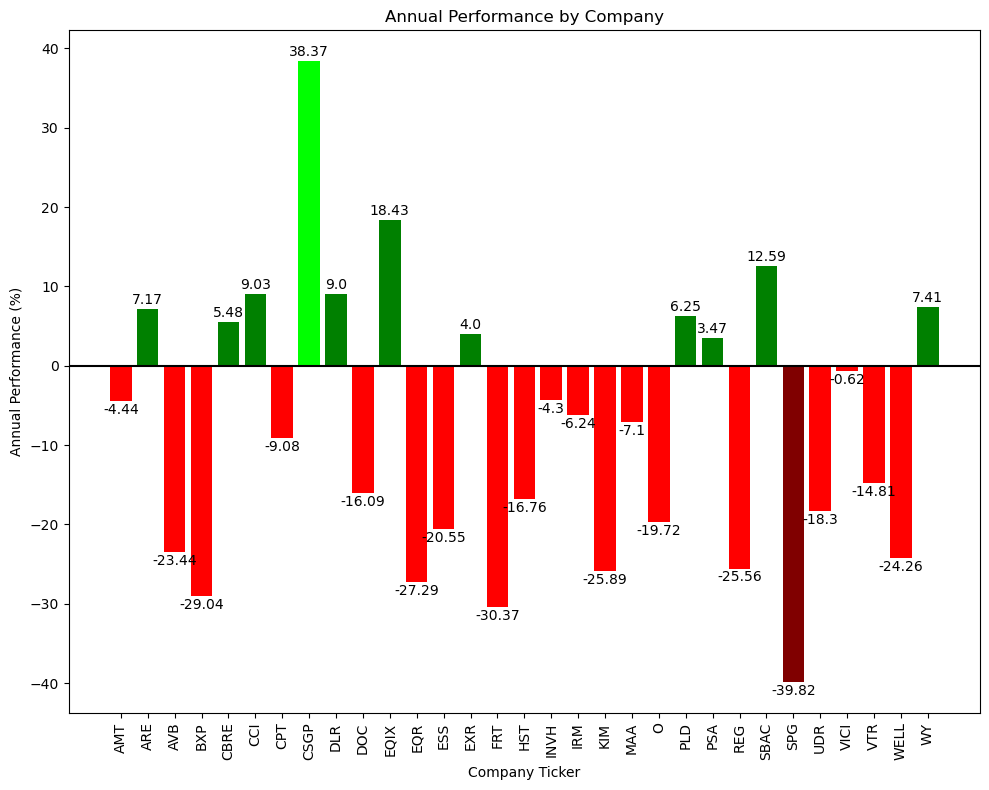

In [44]:
# Bar Graph Visualization

# Assign colors based on annual performance values
colors = []
max_annual_pref = annual_pref_data["Annual Performance"].max()
min_annual_pref = annual_pref_data["Annual Performance"].min()

for rates in annual_pref_data["Annual Performance"]:
    if rates == max_annual_pref:
        colors.append("lime")
    elif rates == min_annual_pref:
        colors.append("maroon")
    else:
        colors.append("green" if rates >= 0 else "red")

# Creating an area for the graph
plt.figure(figsize=(10, 8))

# Plotting the bar graph and assign the lables 
annual_bars = plt.bar(annual_pref_data["Symbol"], annual_pref_data["Annual Performance"], color=colors)
plt.xlabel("Company Ticker")
plt.ylabel("Annual Performance (%)")
plt.title("Annual Performance by Company") 
plt.xticks(rotation=90)

# Adding a breakpoint line
plt.axhline(y=0, color="black", linewidth=1.5)

# Adding  positioning values to accuratly display and cleanly display values on top of the bars
for bar in annual_bars:
    annual_values = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 
             annual_values + 2 if annual_values > 0 else annual_values -2, 
             round(annual_values, 2), ha="center" ,va= "top" if annual_values > 0 else "bottom")

# Accurately displaying the graph
plt.tight_layout() 

# Showing the graph
plt.show()

In [32]:
# Calculating Monthly ROR
final_stock["ROR (by month)"] = ((final_stock["Open"]-final_stock["Close"])/final_stock["Open"])*100
final_stock.head()

Symbol Date   Close    High     Low    Open      Volume  ROR (by month)
4    AMT  Jan  232.61  234.25  230.90  232.44  1490361.90       -0.073137
3    AMT  Feb  244.26  247.06  241.70  244.30  2105152.63        0.016373
7    AMT  Mar  222.87  230.62  213.32  220.18  3515518.18       -1.221728
0    AMT  Apr  242.19  246.92  236.87  242.07  2490004.76       -0.049572
8    AMT  May  238.06  241.06  234.24  237.92  1975800.00       -0.058843